In [1]:
import matplotlib.pyplot as plt
import json
import itertools
import pandas as pd
import numpy as np

In [2]:
with open('results.json') as f:
    data = json.load(f)
    
data_list = []

for run_idx, run in enumerate(data):
        
    for planner_run in run['planner_runs']:
        for ptp_idx, ptp_run in enumerate(planner_run['segments']):
            data_list.append({
                'run_idx': run_idx,
                'ptp_idx': ptp_idx,
                'apples': run['number_of_apples'],
                **planner_run,
                **ptp_run
            })
            
data_df = pd.DataFrame(data_list).sort_values(['run_idx','ptp_idx'])
apples_xyz = pd.DataFrame(data_df['apple'].to_list(), columns=['x','y','z'])

for dim in 'xyz':
    data_df['apple_'+dim] = apples_xyz[dim]
    
data_df['distance_euclidean'] = np.sqrt((data_df[['apple_x','apple_y','apple_z']] - data_df[['apple_x','apple_y','apple_z']].shift(1)).pow(2).sum(axis=1))
data_df.drop(data_df[data_df.ptp_idx == 0].index)

del data_df['apple']
del apples_xyz

In [3]:
data_df

,run_idx,ptp_idx,apples,intermediate_planner,is_collision_free,leaf_collisions_over_time,ordering,segments,unique_leaves_collided,path_length,solved,apple_x,apple_y,apple_z,distance_euclidean
0,0,0,65,PRM,True,"[{'contacts_ended': 0, 'new_leaves_in_contact'...",1-NN,"[{'apple': [-2.007330352442006, -4.11432157291...",383,68.845562,True,-2.007330,-4.114322,5.896829,0.000000
65,0,0,65,PRMstar,True,"[{'contacts_ended': 0, 'new_leaves_in_contact'...",1-NN,"[{'apple': [-2.007330352442006, -4.11432157291...",231,74.193898,True,-1.482453,-2.484480,4.508855,2.204166
130,0,0,65,PRM,True,"[{'contacts_ended': 0, 'new_leaves_in_contact'...",2-NN,"[{'apple': [-2.007330352442006, -4.11432157291...",252,89.123134,True,-1.098987,-3.807636,3.780132,1.558468
195,0,0,65,PRMstar,True,"[{'contacts_ended': 0, 'new_leaves_in_contact'...",2-NN,"[{'apple': [-2.1118751271539162, -3.7199008382...",514,82.020006,True,-1.221783,-2.364073,6.408312,3.001047
260,0,0,65,PRM,True,"[{'contacts_ended': 0, 'new_leaves_in_contact'...",3-NN,"[{'apple': [-2.1118751271539162, -3.7199008382...",487,84.094876,True,0.285628,-2.393849,3.386682,3.376895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25679,49,29,30,PRMstar,True,"[{'contacts_ended': 0, 'new_leaves_in_contact'...",U-2-NN,"[{'apple': [-3.6642772959782985, -5.0125326132...",131,86.918592,True,3.789398,-1.032821,4.781327,0.000000
25709,49,29,30,PRM,True,"[{'contacts_ended': 0, 'new_leaves_in_contact'...",U-3-NN,"[{'apple': [-3.6642772959782985, -5.0125326132...",146,24.257574,True,5.902815,-1.146895,2.062644,3.445400
25739,49,29,30,PRMstar,True,"[{'contacts_ended': 0, 'new_leaves_in_contact'...",U-3-NN,"[{'apple': [-3.6642772959782985, -5.0125326132...",131,97.825141,True,3.612917,-3.711927,3.598390,3.765839
25769,49,29,30,PRM,True,NaN,random,"[{'apple': [0.7031066837227263, 0.510551079190...",0,250.478486,True,3.500254,-1.383503,6.408213,3.650939


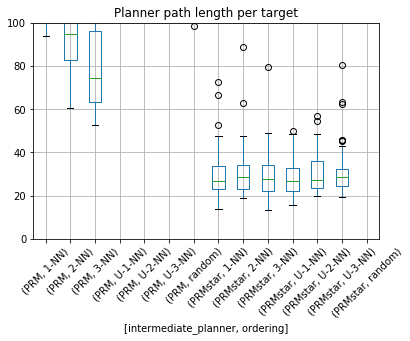

In [12]:
data_df[(data_df.solved) & (data_df.ptp_idx != 0)]\
    .groupby(['intermediate_planner', 'ordering', 'run_idx'])\
    .path_length\
    .mean()\
    .to_frame()\
    .boxplot(by=['intermediate_planner','ordering'], rot=45)

plt.ylim(0,100)
plt.title('Planner path length per target')
plt.suptitle('')
plt.savefig('path_length_per_target.png')
plt.show()

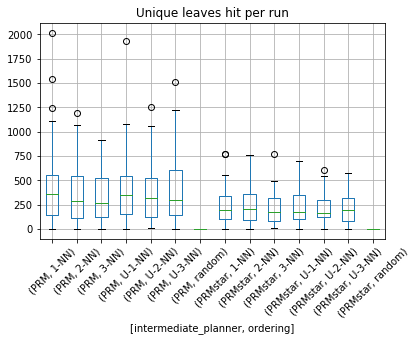

In [5]:
data_df[(data_df.solved) & (data_df.ptp_idx != 0)]\
    .groupby(['intermediate_planner', 'ordering', 'run_idx'])\
    .unique_leaves_collided\
    .mean()\
    .to_frame()\
    .boxplot(by=['intermediate_planner','ordering'], rot=45)

plt.title('Unique leaves hit per run')
plt.suptitle('')
plt.savefig('leaves_hit_per_target.png')
plt.show()

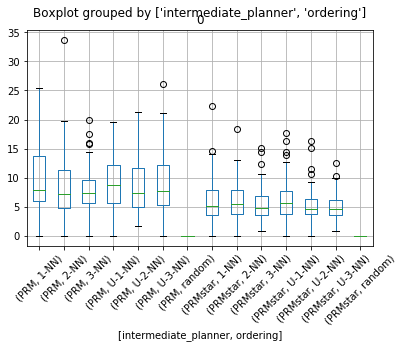

In [6]:
by_run = data_df[(data_df.solved) & (data_df.ptp_idx != 0)].groupby(['intermediate_planner', 'ordering', 'run_idx']).first()
(by_run.unique_leaves_collided / by_run.apples).reset_index(['intermediate_planner', 'ordering']).boxplot(by=['intermediate_planner','ordering'], rot=45)

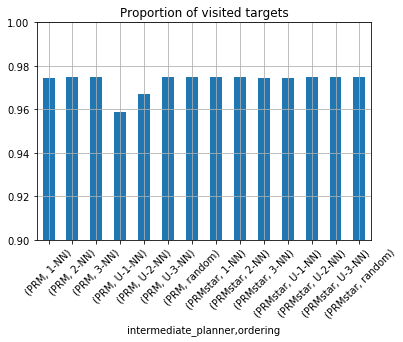

In [7]:
solved_agg = data_df[(data_df.ptp_idx != 0)].groupby(['intermediate_planner', 'ordering','run_idx']).agg({'solved':'sum','apples':'first'})
solved_agg = solved_agg.groupby(['intermediate_planner', 'ordering']).sum()
solved_proportion = solved_agg.solved / solved_agg.apples
solved_proportion.plot(kind='bar',rot=45,grid=True)

plt.ylim(0.9,1)
plt.title('Proportion of visited targets')
plt.savefig('proportion_visited_targets.png')
plt.show()

NameError: name 'ply' is not defined

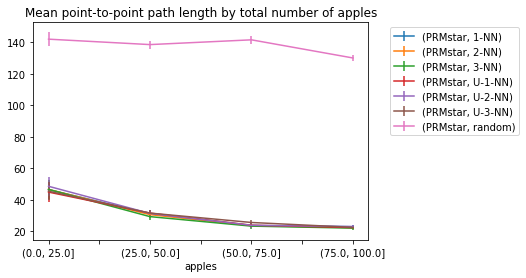

In [14]:
bins = np.linspace(0,100,5)

grouped = data_df.groupby(['intermediate_planner', 'ordering'])

for label, df in grouped:
    if label[0] != 'PRM':
        agg = df.groupby(pd.cut(df.apples, bins)).path_length.agg(['mean','std','count'])
        agg['std_error'] = agg['std'] / np.sqrt(agg['count'])


        agg['mean'].plot(label=label, yerr=1.96 * agg['std_error'])
    
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Mean point-to-point path length by total number of apples")
plt.savefig('mean_ptp_length_by_num_apples.png')
ply.ylim(0,60)
plt.grid()
plt.show()

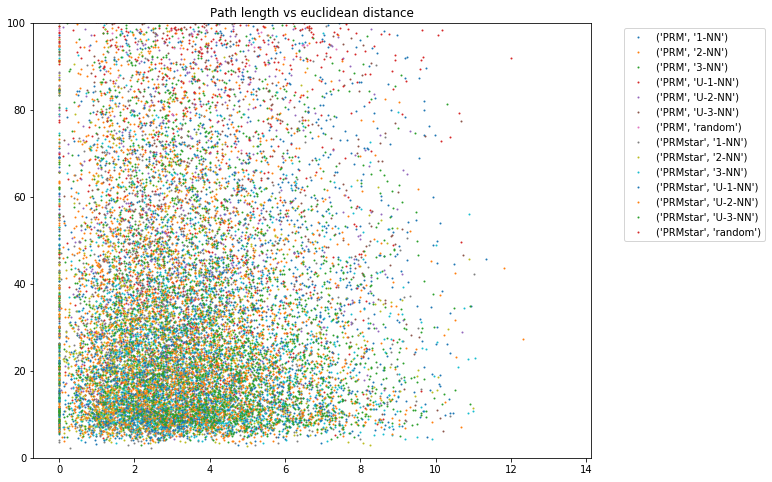

In [9]:
plt.figure(figsize=(10,8))
for label, df in data_df.groupby(['intermediate_planner', 'ordering']):
    plt.scatter(df['distance_euclidean'],df['path_length'],label=label,s=1)
    
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Path length vs euclidean distance')
plt.ylim(0,100)
plt.show()

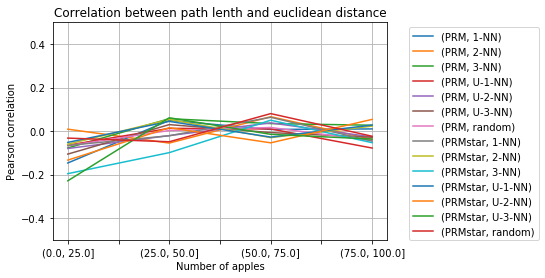

In [10]:
bins = np.linspace(0,100,5)

corr = data_df.groupby(['intermediate_planner', 'ordering',pd.cut(data_df.apples, bins)])[['distance_euclidean','path_length']].corr()
corr = corr.reset_index(3)
corr = corr.path_length[corr.level_3 == 'distance_euclidean']
for label, df in corr.groupby(['intermediate_planner', 'ordering']):
    df.reset_index(['intermediate_planner', 'ordering'], drop=True).plot(label=label)

plt.grid()
plt.ylim(-0.5,0.5)
plt.xlabel('Number of apples')
plt.ylabel('Pearson correlation')
plt.title('Correlation between path lenth and euclidean distance')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [11]:
df = pd.DataFrame(data[0]['leaf_collisions_over_time']).sort_values('t').set_index('t')
(df.new_leaves_in_contact - df.contacts_ended).cumsum().plot()

KeyError: 'leaf_collisions_over_time'